In [70]:
import math
import random
import itertools
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import seaborn as sns
from tqdm import tqdm
from statistics import mean, stdev

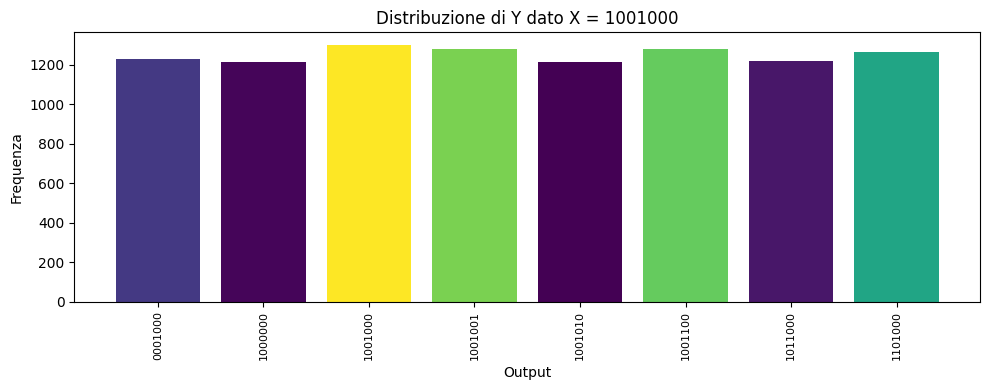

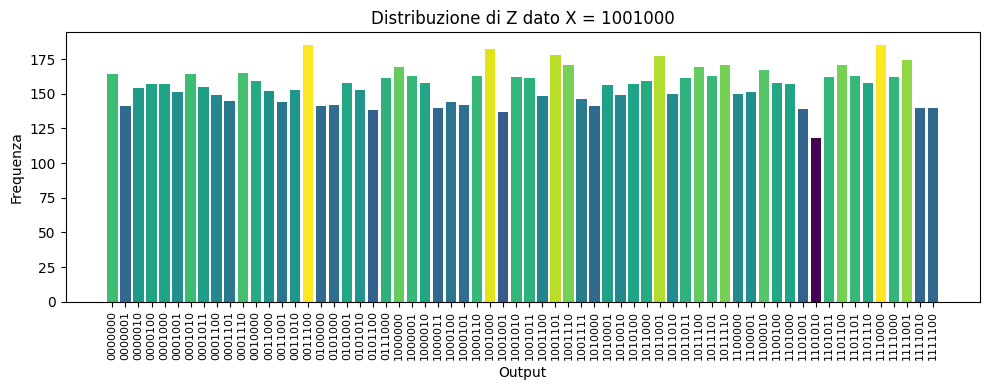

In [ ]:
def hamming_distance(a, b):
    return sum(x != y for x, y in zip(a, b))

def generate_error_set(x, max_errors):
    """
    Genera tutti i vettori binari a distanza di Hamming ≤ max_errors da x.
    """
    n = len(x)
    neighbors = set()
    x_int = int(x, 2)

    # Nessun errore
    neighbors.add(x_int)

    for num_errors in range(1, max_errors + 1):
        for bit_positions in itertools.combinations(range(n), num_errors):
            error_mask = sum(1 << pos for pos in bit_positions)
            neighbors.add(x_int ^ error_mask)

    return [format(v, f"0{n}b") for v in neighbors]

def wiretap_channel(x):
    """
    Simula il canale wiretap:
    - y: output del legittimo ricevitore (max 1 errore)
    - z: output dell'eavesdropper (max 3 errori)
    """
    Ty = generate_error_set(x, 1)
    Tz = generate_error_set(x, 3)
    y = random.choice(Ty)
    z = random.choice(Tz)
    return y, z

def run_experiment(x, num_samples=10000):
    y_samples = []
    z_samples = []

    for _ in range(num_samples):
        y, z = wiretap_channel(x)
        y_samples.append(y)
        z_samples.append(z)

    return y_samples, z_samples

def plot_distribution(samples, title):
    counter = Counter(samples)
    labels, counts = zip(*sorted(counter.items()))
    plt.figure(figsize=(10, 4))
    plt.bar(labels, counts, color=plt.get_cmap("viridis")(rescale(counts)))
    plt.xticks(rotation=90, fontsize=8)
    plt.title(title)
    plt.xlabel("Output")
    plt.ylabel("Frequenza")
    plt.tight_layout()
    plt.show()
    
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

x_input = "1001000"
y_samples, z_samples = run_experiment(x_input, 10000)
plot_distribution(y_samples, "Distribuzione di Y dato X = 1001000")
plot_distribution(z_samples, "Distribuzione di Z dato X = 1001000")


Come si può notare dai grafici, ogni possibile output di Y e Z compare con la stessa frequenza indicando che gli output dei 2 canali sono uniformemente distribuiti

In [72]:
def compute_tvd(y_samples, z_samples):
    joint_counter = Counter(zip(y_samples, z_samples))
    y_counter = Counter(y_samples)
    z_counter = Counter(z_samples)
    n = len(y_samples)

    tvd = 0
    for (y, z), joint_freq in joint_counter.items():
        py = y_counter[y] / n
        pz = z_counter[z] / n
        p_joint = joint_freq / n
        p_product = py * pz
        tvd += abs(p_joint - p_product)
    
    tvd *= 0.5
    return tvd

tvd_value = compute_tvd(y_samples, z_samples)
print(f"Total Variation Distance: {tvd_value:.5f}")


Total Variation Distance: 0.08454


Una TDV approssimabile a 0 indica che gli output sono quasi totalmente indipendenti

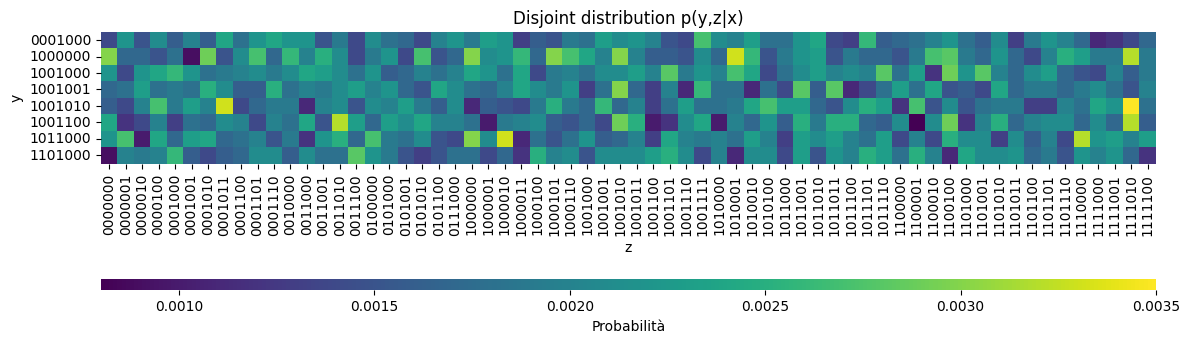

In [ ]:
def plot_joint_heatmap(y_samples, z_samples, title="Disjoint distribution p(y,z|x)"):
    # Prendi gli insiemi ordinati di y e z
    y_vals = sorted(set(y_samples))
    z_vals = sorted(set(z_samples))

    y_idx = {val: i for i, val in enumerate(y_vals)}
    z_idx = {val: i for i, val in enumerate(z_vals)}

    # Matrice vuota
    joint_matrix = np.zeros((len(y_vals), len(z_vals)))

    # Riempi la matrice con le frequenze
    for y, z in zip(y_samples, z_samples):
        joint_matrix[y_idx[y], z_idx[z]] += 1

    # Normalizza (frequenze relative)
    joint_matrix /= len(y_samples)

    plt.figure(figsize=(12, 8))
    sns.heatmap(joint_matrix, xticklabels=z_vals, yticklabels=y_vals, cmap="viridis", cbar_kws={'label': 'Probabilità', "orientation": "horizontal", "aspect" : 100}, square=True, )
    plt.title(title)
    plt.xlabel("z")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

plot_joint_heatmap(y_samples, z_samples)

L'heatmap non evidenzia pattern di correlazione tra Y e Z con probabilità significative. Ciò indica che i canali producono output condizionalmente indipendenti  

In [74]:
# Lista delle 16 codeword del codice di Hamming (7,4)
HAMMING_CODEWORDS = [
    "0000000", "1000110", "0100101", "0010011",
    "0001111", "1100011", "1010101", "1001001",
    "0110110", "0101010", "0011100", "1110000",
    "1101100", "1011010", "0111001", "1111111"
]

def complement(bits):
    return ''.join('1' if b == '0' else '0' for b in bits)

def get_bin_for_message(u):
    """
    Restituisce il bin associato al messaggio u (3 bit).
    """
    assert len(u) == 3 and set(u) <= {'0', '1'}

    bin_prefix = "0" + u  # Costruisci [0, u] come prefisso (4 bit)
    
    for cw in HAMMING_CODEWORDS:
        if cw.startswith(bin_prefix):
            comp = complement(cw)
            if comp in HAMMING_CODEWORDS:
                return [cw, comp]
            else:
                return [cw]  # fallback in caso di errore
    raise ValueError(f"Nessuna codeword con prefisso [0, {u}] trovata.")

def random_binning_encoder(u):
    """
    Implementa l'encoder di binning casuale:
    prende un messaggio u ∈ M (stringa a 3 bit) e restituisce una codeword x ∈ X′
    """
    bin_codewords = get_bin_for_message(u)
    return random.choice(bin_codewords)

# Test encoder
for u in ["000", "001", "010", "011", "100", "101", "110", "111"]:
    bin_set = get_bin_for_message(u)
    print(f"Messaggio {u} → bin: {bin_set}")


Messaggio 000 → bin: ['0000000', '1111111']
Messaggio 001 → bin: ['0001111', '1110000']
Messaggio 010 → bin: ['0010011', '1101100']
Messaggio 011 → bin: ['0011100', '1100011']
Messaggio 100 → bin: ['0100101', '1011010']
Messaggio 101 → bin: ['0101010', '1010101']
Messaggio 110 → bin: ['0110110', '1001001']
Messaggio 111 → bin: ['0111001', '1000110']


In [75]:
def hamming_distance(a, b):
    return sum(x != y for x, y in zip(a, b))

def decode_message_from_codeword(x_hat):
    """
    Estrae il messaggio û da una codeword.
    Se il primo bit è 0: prende [x₂ x₃ x₄]
    Se il primo bit è 1: prende il complemento di [x₂ x₃ x₄]
    """
    info_bits = x_hat[1:4]
    if x_hat[0] == '0':
        return info_bits
    else:
        return complement(info_bits)

def legit_decoder(y):
    """
    Implementa il decoder:
    - trova la codeword x̂ con minima distanza da y
    - estrae û dai bit informativi
    """
    x_hat = min(HAMMING_CODEWORDS, key=lambda cw: hamming_distance(y, cw))
    return decode_message_from_codeword(x_hat)


In [76]:
def test_encoder_decoder():
    correct = 0
    trials = 1000
    for _ in tqdm(range(trials)):
        u = format(random.randint(0, 7), "03b")
        x = random_binning_encoder(u)
        y = x  # niente rumore per ora
        u_hat = legit_decoder(y)
        if u_hat == u:
            correct += 1
        print("Starting message: ", u)
        print("Crypted messagge: ", y)
        print("Decryption:       ", u_hat , '\n')
    print(f"Accuratezza decoder (senza errori): {correct}/{trials}")

test_encoder_decoder()


100%|██████████| 1000/1000 [00:00<00:00, 22704.07it/s]

Starting message:  000
Crypted messagge:  0000000
Decryption:        000 

Starting message:  000
Crypted messagge:  0000000
Decryption:        000 

Starting message:  010
Crypted messagge:  1101100
Decryption:        010 

Starting message:  000
Crypted messagge:  0000000
Decryption:        000 

Starting message:  101
Crypted messagge:  1010101
Decryption:        101 

Starting message:  000
Crypted messagge:  0000000
Decryption:        000 

Starting message:  111
Crypted messagge:  0111001
Decryption:        111 

Starting message:  010
Crypted messagge:  1101100
Decryption:        010 

Starting message:  101
Crypted messagge:  1010101
Decryption:        101 

Starting message:  011
Crypted messagge:  1100011
Decryption:        011 

Starting message:  000
Crypted messagge:  0000000
Decryption:        000 

Starting message:  111
Crypted messagge:  1000110
Decryption:        111 

Starting message:  011
Crypted messagge:  0011100
Decryption:        011 

Starting message:  010
Cr

In [77]:
def apply_legitimate_channel(x):
    """
    Simula il canale legittimo che introduce al massimo 1 errore.
    """
    error_patterns = generate_error_set(x, 1)
    return random.choice(error_patterns)

def test_encoder_channel_decoder():
    correct = 0
    trials = 1000
    for _ in tqdm(range(trials)):
        u = format(random.randint(0, 7), "03b")
        x = random_binning_encoder(u)
        y = apply_legitimate_channel(x)  # 0 o 1 errore
        u_hat = legit_decoder(y)
        if u_hat == u:
            correct += 1
        print("Starting message:               ", u)
        print("Crypted messagge:               ", x)
        print("Crypted messagge after channel: ", y)
        print("Decryption:                     ", u_hat , '\n')
    print(f"Accuratezza decoder con canale (1 errore max): {correct}/{trials}")

test_encoder_channel_decoder()


100%|██████████| 1000/1000 [00:00<00:00, 15803.11it/s]

Starting message:                011
Crypted messagge:                0011100
Crypted messagge after channel:  0111100
Decryption:                      011 

Starting message:                100
Crypted messagge:                0100101
Crypted messagge after channel:  0100111
Decryption:                      100 

Starting message:                100
Crypted messagge:                0100101
Crypted messagge after channel:  0100001
Decryption:                      100 

Starting message:                010
Crypted messagge:                0010011
Crypted messagge after channel:  0010010
Decryption:                      010 

Starting message:                101
Crypted messagge:                1010101
Crypted messagge after channel:  1000101
Decryption:                      101 

Starting message:                010
Crypted messagge:                1101100
Crypted messagge after channel:  1101101
Decryption:                      010 

Starting message:                010
Crypted messagg

In [78]:
def apply_eavesdropper_channel(x):
    """
    Simula il canale di Eve che introduce fino a 3 errori.
    """
    error_patterns = generate_error_set(x, 3)
    return random.choice(error_patterns)

def simulate_encoder_eavesdropper_chain(n_samples_per_u=2000):
    u_values = [format(i, "03b") for i in range(8)]
    z_given_u = defaultdict(list)

    for u in u_values:
        for _ in range(n_samples_per_u):
            x = random_binning_encoder(u)
            z = apply_eavesdropper_channel(x)
            z_given_u[u].append(z)
    
    return z_given_u

In [79]:
def compute_empirical_distributions(z_given_u):
    # Conta congiunta p̂(u, z)
    joint_counts = Counter()
    u_counts = Counter()
    z_counts = Counter()
    total = 0

    for u, z_list in z_given_u.items():
        for z in z_list:
            joint_counts[(u, z)] += 1
            u_counts[u] += 1
            z_counts[z] += 1
            total += 1

    # Calcolo p̂(u), p̂(z), p̂(u,z)
    p_u = {u: u_counts[u] / total for u in u_counts}
    p_z = {z: z_counts[z] / total for z in z_counts}
    p_joint = {(u, z): joint_counts[(u, z)] / total for (u, z) in joint_counts}

    # Calcolo Î(u; z)
    I = 0
    for (u, z), p_uz in p_joint.items():
        p_u_val = p_u[u]
        p_z_val = p_z[z]
        I += p_uz * math.log2(p_uz / (p_u_val * p_z_val))

    return p_u, p_z, p_joint, I

In [80]:
z_given_u = simulate_encoder_eavesdropper_chain()
p_u, p_z, p_joint, I_hat = compute_empirical_distributions(z_given_u)

print(f"Mutua informazione empirica Î(u; z) = {I_hat:.6f} bits")


Mutua informazione empirica Î(u; z) = 0.039644 bits
